In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter,zoom
from scipy.interpolate import griddata
from itertools import combinations
import random
from sklearn.neighbors import KNeighborsRegressor

from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Convolution2D, Dense, Flatten, MaxPooling2D, Lambda,Conv2DTranspose
from keras.optimizers import Adam

import cv2

Using TensorFlow backend.


In [2]:
#data2
npzfile = np.load('/home/datawork-lops-osi/feyan/data_na/u1000_v3.npz')
u_n=npzfile['u'][180:]
npzfile = np.load('/home/datawork-lops-osi/feyan/data_na/v1000_v3.npz')
v_n=npzfile['v'][180:]

In [3]:
u_n.shape

(1000, 720, 720)

In [4]:
#data2
npzfile = np.load('/home/datawork-lops-osi/feyan/data_na/u1000_v3.npz')
u_test=npzfile['u'][:180]
npzfile = np.load('/home/datawork-lops-osi/feyan/data_na/v1000_v3.npz')
v_test=npzfile['v'][:180]

In [38]:
u_test.shape

(180, 720, 720)

In [5]:
stp=np.arange(u_n.shape[0])
ekeu=((u_n**2).mean(axis=1)).mean(axis=1)
ekev=((v_n**2).mean(axis=1)).mean(axis=1)
plt.plot(stp[:],(ekeu+ekev)[:])
plt.title('Total KE  ', fontsize=18)
plt.xlabel('days', fontsize=14)
plt.grid()

In [6]:
nf=18
nci=u_n.shape[1]//nf

u_c=np.zeros((u_n.shape[0],nci,nci))
v_c=np.zeros((u_n.shape[0],nci,nci))
for i in range(u_n.shape[0]):    
    u_c[i]=u_n[i].reshape((nci,u_n[i].shape[0]//nci,nci,-1)).mean(axis=3).mean(1)
    v_c[i]=v_n[i].reshape((nci,v_n[i].shape[0]//nci,nci,-1)).mean(axis=3).mean(1)

In [40]:
u_test1=np.zeros((u_test.shape[0],nci,nci))
for i in range(u_test.shape[0]):    
    u_test1[i]=u_test[i].reshape((nci,u_test[i].shape[0]//nci,nci,-1)).mean(axis=3).mean(1)  

In [7]:
u=u_n
v=v_n

um=u_c
vm=v_c

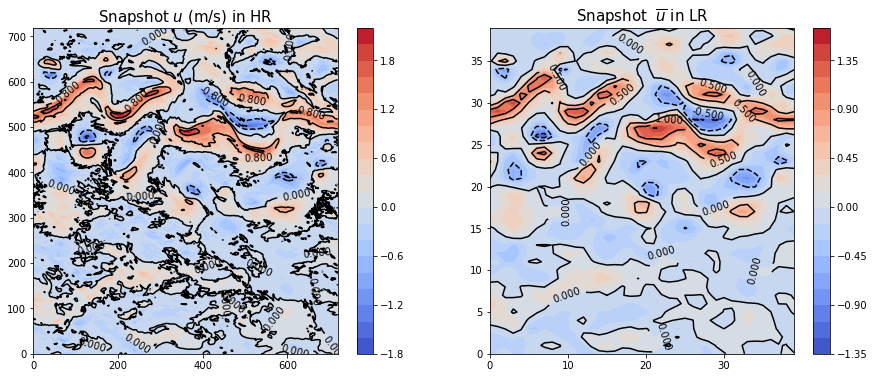

In [8]:
plt.figure(figsize=(15,6))
ni=950
plo=u
plm=um

plt.subplot(121)
plt.contourf(plo[ni],20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
CS1=plt.contour(plo[ni],5,colors = ('k',)); 
plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('Snapshot $u$ (m/s) in HR',fontsize=15)

plt.subplot(122)
plt.contourf(plm[ni],20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
CS1=plt.contour(plm[ni],5,colors = ('k',)); 
plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('Snapshot  $\overline{u} $ in LR',fontsize=15)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

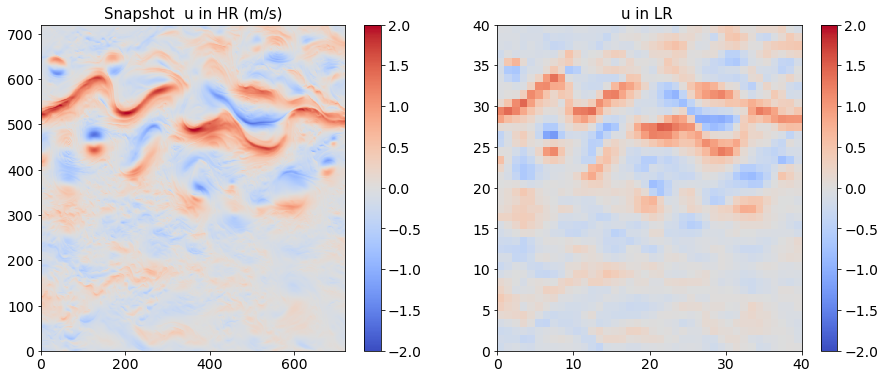

In [8]:
plt.figure(figsize=(15,6))
ni=950
plt.subplot(121)
plt.pcolor(u[ni],cmap='coolwarm',vmax=2,vmin=-2)#,,,vmax=.8,vmin=-.8
cb=plt.colorbar()
plt.title('Snapshot  u in HR (m/s)',fontsize=15)
plt.subplot(122)
pa=um[ni]
plt.pcolor(pa,cmap='coolwarm',vmax=2,vmin=-2)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title( 'u in LR ',fontsize=15)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

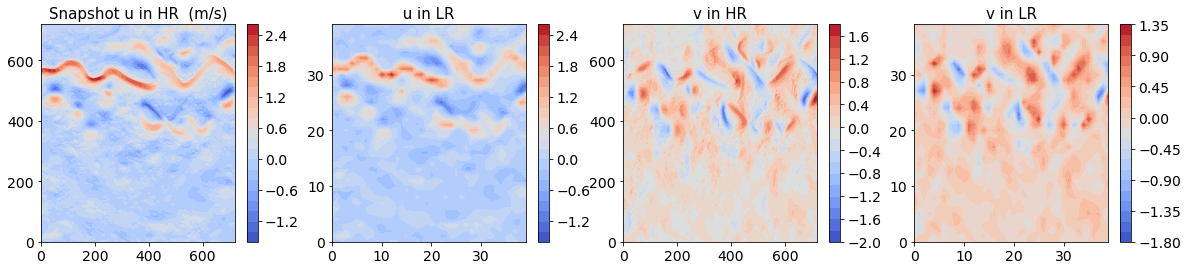

In [51]:
plt.figure(figsize=(20,4))

ni=805

plt.subplot(141)
plt.contourf(u[ni],20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
#CS1=plt.contour(u[ni],5,colors = ('k',)); 
#plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('Snapshot u in HR  (m/s)',fontsize=15)

plt.subplot(142)
plt.contourf(um[ni],20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
#CS1=plt.contour(um[ni],5,colors = ('k',)); 
#plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title(' u in LR ',fontsize=15)

plt.subplot(143)
plt.contourf(v[ni],20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
#CS1=plt.contour(v[ni],5,colors = ('k',)); 
#plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('v in HR',fontsize=15)

plt.subplot(144)
plt.contourf(vm[ni],20,cmap='coolwarm')#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
#CS1=plt.contour(vm[ni],5,colors = ('k',)); 
#plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('v in LR',fontsize=15)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

########################################################################
# Data Preparation Functions
########################################################################

In [9]:
def calcEddyForcing(u1,v1,ubar,vbar):

    # spatial-resolution of  model 
    dx = 2.5*1e3
    l=18*dx
    
    u=u1
    v=v1
    U=ubar
    V=vbar

    
    # Calcluate filtered-advection term
    [ _, U_y, U_x ] = np.gradient( U, 8*dx )
    [ _, V_y, V_x ] = np.gradient( V, 8*dx )

    # ( Ud/dx + Vd/dy )U and ( Ud/dx + Vd/dy )V
    adv1_x = U * U_x + V * U_y
    adv1_y = U * V_x + V * V_y

    del U_x, U_y, V_x, V_y

    # Calculate sub-filter advection term
    [_, u_y, u_x] = np.gradient(u, dx)
    [_, v_y, v_x] = np.gradient(v, dx)

    # ( ud/dx + vd/dy )u + ( ud/dx + vd/dy )v
    adv2_x = u * u_x + v * u_y
    adv2_y = u * v_x + v * v_y

    del u_x, u_y, v_x, v_y
    
    nf=int(l/dx)
    a_x=np.zeros(U.shape)
    a_y=np.zeros(U.shape)
    for i in range(u_n.shape[0]):
        a_x[i]=adv2_x[i].reshape((nci,adv2_x[i].shape[0]//nci,nci,-1)).mean(axis=3).mean(1)
        a_y[i]=adv2_y[i].reshape((nci,adv2_y[i].shape[0]//nci,nci,-1)).mean(axis=3).mean(1)
        
                  
    # Calculate the eddy momentum forcing components
    Sx = adv1_x - a_x
    Sy = adv1_y - a_y

    return Sx, Sy

In [10]:
Sx,Sy=calcEddyForcing(u,v,um,vm)
Sx.shape

(1000, 40, 40)

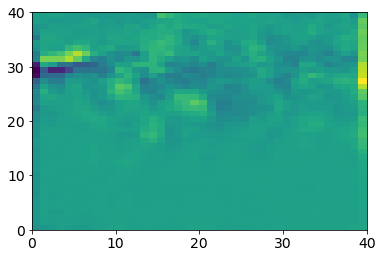

In [11]:
plt.pcolor(Sx.mean(axis=0))

In [12]:
def loadAndNormDataS(u_1,s_1,MOMENTUM_B=False ):
    nt=nci
    nti1=int(um.shape[0]*0.6)
    nti2=int(um.shape[0]*0.8)
 
    S=s_1
    psiFilt=u_1
    
    mu1, sigma1 = np.mean( psiFilt), np.std( psiFilt )
    mu2, sigma2 = np.mean( S ), np.std( S )
    
    psiFilt = (psiFilt - mu1) / sigma1
    S = (S - mu2) / sigma2

    scalings = [mu1, sigma1, mu2, sigma2]
    
    xTrain, xVal, xTest = psiFilt[:nti1, :, :], psiFilt[nti1:nti2, :, :],psiFilt[nti2:, :, :]
    yTrain, yVal,yTest = S[:nti1, :, :], S[nti1:nti2, :, :],S[nti2:, :, :]
    
    # add singleton dimension for input variables (this is for Keras)
    xTrain = np.reshape(xTrain, (-1, nt, nt, 1))
    xVal = np.reshape(xTest, (-1, nt, nt, 1))
    xTest = np.reshape(xVal, (-1, nt, nt, 1))

    # reshape outputs from 2D (40x40) to 1D vector 1600
    #yTrain = np.reshape(yTrain, (-1, nt * nt))
    #yTest = np.reshape(yTest, (-1, nt * nt)) 
    yTrain = np.reshape(yTrain, (-1, nt, nt, 1))
    yVal = np.reshape(yTest, (-1, nt, nt, 1))
    yTest = np.reshape(yTest, (-1, nt, nt, 1))

    return xTrain, yTrain, xTest, yTest, xVal,yVal,scalings

In [13]:
xTrain, yTrain, xTest, yTest, xVal,yVal, scalings =loadAndNormDataS(um,Sx,MOMENTUM_B=False )

In [14]:
xTrain.shape

(600, 40, 40, 1)

In [15]:
def trainCNN_S(u_3,s_3 ) : 
    nt=nci
    # load data 
    xTrain, yTrain, xTest, yTest, xVal,yVal, scalings = loadAndNormDataS(u_3,s_3,MOMENTUM_B=False )

    # number of training and validation samples
    nTrain = xTrain.shape[0]
    nTest = xTest.shape[0]

    print ("Number of training samples: ", nTrain)
    print ("Number of validation samples: ", nTest)

    ########## Construct Layers ##########

    input_layer = Input( shape=( nt, nt, 1 ) )

    # Convolution layers
    conv_1 = Convolution2D( 32, (9,9), padding='valid', activation='relu')( input_layer )
    conv_2 = Convolution2D( 16, (1,1), padding='valid', activation='relu')( conv_1 )
    #conv_3 = Convolution2D( 32, (5,5), padding='valid', activation='relu')( conv_2 )
    output_layer = Conv2DTranspose(1,(9,9),padding='valid')(conv_2)
    

    # Max Pooling
    #pool_1 = MaxPooling2D( pool_size=(2,2) )( conv_3 )
   
    
    #flat = Flatten()(pool_1)
    #output_layer = Dense( units=40*40, activation='linear' )( flat )
       
    ########## Train CNN ###########

    myModel = Model( inputs=input_layer, outputs=output_layer )
    myOpt = Adam( lr=0.001 )
    myModel.compile( loss='mean_squared_error', optimizer=myOpt )#,metrics=['accuracy']
    

    # show the architecture and the parameters
    print (myModel.summary())

    # train the model
    History = myModel.fit( xTrain, yTrain, batch_size=128, epochs=200, verbose=2, validation_data=( xTest, yTest )  )
    
    #fileName='model'
    #myModel.save( fileName + '.h5' )
    
    return myModel,History

In [16]:
model,History=trainCNN_S(um,Sx)

Number of training samples:  600
Number of validation samples:  200
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2624      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 16)        528       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 40, 40, 1)         1297      
Total params: 4,449
Trainable params: 4,449
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 600 samples, validate on 200 samples
Epoch 1/200
 - 2s - loss: 1.0167 

 - 1s - loss: 0.3767 - val_loss: 0.3792
Epoch 126/200
 - 1s - loss: 0.3767 - val_loss: 0.3787
Epoch 127/200
 - 1s - loss: 0.3767 - val_loss: 0.3780
Epoch 128/200
 - 1s - loss: 0.3762 - val_loss: 0.3778
Epoch 129/200
 - 1s - loss: 0.3759 - val_loss: 0.3778
Epoch 130/200
 - 1s - loss: 0.3759 - val_loss: 0.3770
Epoch 131/200
 - 1s - loss: 0.3749 - val_loss: 0.3767
Epoch 132/200
 - 1s - loss: 0.3744 - val_loss: 0.3775
Epoch 133/200
 - 1s - loss: 0.3743 - val_loss: 0.3778
Epoch 134/200
 - 1s - loss: 0.3741 - val_loss: 0.3767
Epoch 135/200
 - 1s - loss: 0.3735 - val_loss: 0.3762
Epoch 136/200
 - 1s - loss: 0.3731 - val_loss: 0.3757
Epoch 137/200
 - 1s - loss: 0.3727 - val_loss: 0.3752
Epoch 138/200
 - 1s - loss: 0.3725 - val_loss: 0.3752
Epoch 139/200
 - 1s - loss: 0.3721 - val_loss: 0.3752
Epoch 140/200
 - 1s - loss: 0.3719 - val_loss: 0.3745
Epoch 141/200
 - 1s - loss: 0.3715 - val_loss: 0.3742
Epoch 142/200
 - 1s - loss: 0.3713 - val_loss: 0.3747
Epoch 143/200
 - 1s - loss: 0.3712 - val_l

In [18]:
plt.figure()
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss', fontsize=20)
plt.ylabel('Loss', fontsize=15)  
plt.xlabel('Epochs', fontsize=15)
plt.legend(['Train','validation'], fontsize=15)#, loc='upper right'
#plt.savefig('modloss.png',dpi=150)
#files.download("modloss.png") 
plt.grid()
plt.show()

 Predicting Functions

In [20]:
def makeOverlapPreds(x, scl, model = model, MOMENTUM_A=False, MOMENTUM_B=False, MOMENTUM_C=False) :
    nt=nci
    nti=int(x.shape[0]*0.8)
    scalings =scl
    shpx=x.shape[2]
    shpy=x.shape[1]
    mu1, sigma1, mu2, sigma2 = scalings[0], scalings[1], scalings[2], scalings[3]

    
    psiFilt = (x - mu1) / sigma1

    SPred = np.zeros( (x.shape[0]-nti,shpy,shpx) )
    
    mask = np.zeros( (shpy,shpx) )

    stride = 2

    for i in range( 0, shpx-nt+1, stride):   # loop through points in x

       #print (i)  # progress update
       for j in range( 0, shpy-nt+1, stride ):   # loop through points in y

          # make predictions at this point
         SPred[:,j:j+nt,i:i+nt] += model.predict( np.reshape( psiFilt[nti:,j:j+nt,i:i+nt], (-1,nt,nt,1) ) ).reshape( (-1,nt,nt) )

          # update number of predictions made at each grid point
         mask[j:j+nt,i:i+nt] += 1

    # average the predictions
    SPred = np.divide( SPred, mask )

    # rescale psi, either Sx or Sy
    
    SPred = SPred * sigma2 + mu2

    return SPred

In [21]:
Spr=makeOverlapPreds(um,scalings)

In [22]:
Spr.shape

(200, 40, 40)

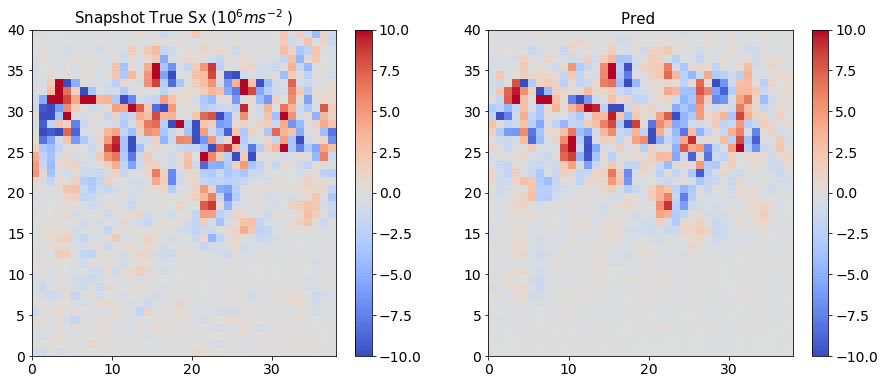

In [23]:
nti=int(um.shape[0]*.8)
plt.figure(figsize=(15,6))
ni=145
plt.subplot(121)
plt.pcolor(Sx[nti+ni,:,1:-1]*1.e6,cmap='coolwarm',vmax=10,vmin=-10)#,,
cb=plt.colorbar()
plt.title('Snapshot True Sx ($10^6 ms^{-2}$ )',fontsize=15)
plt.subplot(122)
pa=(Spr[ni,:,1:-1])*1.e6#-Spr[ni].mean()
plt.pcolor(pa,cmap='coolwarm',vmax=10,vmin=-10)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('Pred ',fontsize=15)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

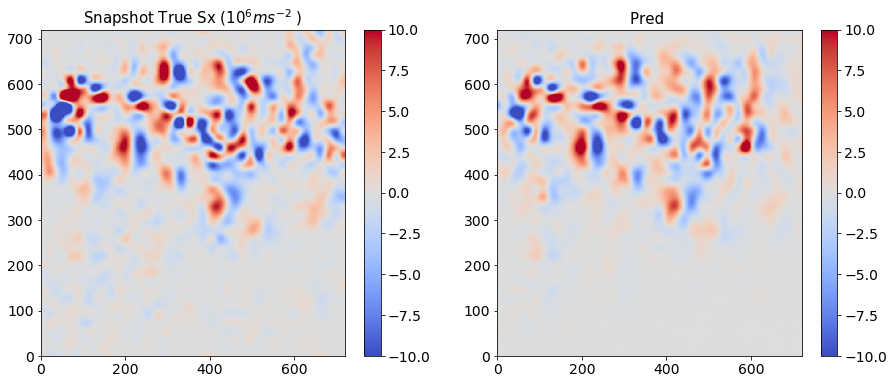

In [36]:
aa=Sx[nti+ni]*1.e6
aa=zoom(aa,18.)
bb=Spr[ni]*1.e6
bb=zoom(bb,18.)
nti=int(um.shape[0]*.8)
plt.figure(figsize=(15,6))
ni=5
plt.subplot(121)
plt.pcolor(aa,cmap='coolwarm',vmax=10,vmin=-10)#,,
cb=plt.colorbar()
plt.title('Snapshot True Sx ($10^6 ms^{-2}$ )',fontsize=15)
plt.subplot(122)
plt.pcolor(bb,cmap='coolwarm',vmax=10,vmin=-10)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('Pred ',fontsize=15)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

In [25]:
plt.figure(figsize=(15,6))
ni=5
nti=int(um.shape[0]*0.8)
plo=Sx[nti:,:,1:-1].mean(axis=0)
plm=Spr[:,:,1:-1].mean(axis=0)


plt.subplot(121)
c=plt.pcolor(plo*1.e6,cmap='coolwarm',vmin=-1.5, vmax=1.5)#,vmin=-4, vmax=5
cb=plt.colorbar(c)
#CS1=plt.contour(xl,yl,plo,5,colors = ('k',));# 
#plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('mean True Sx (1e6)',fontsize=15)

plt.subplot(122)
pa=(plm)*1.e6
c1=plt.pcolor(pa,cmap='coolwarm',vmin=-1.5, vmax=1.5)#vmin=-4, vmax=5
cb=plt.colorbar()
#CS1=plt.contour(xl,yl,plm,5,colors = ('k',)); 
#plt.clabel(CS1, fmt = '%2.3f', colors = 'k', fontsize=10)
plt.title('mean Prediction(1e6)',fontsize=15)

Text(0.5, 1.0, 'mean Prediction(1e6)')

In [31]:
aa=plo*1e6
aa=zoom(aa,18.)
bb=plm*1e6
bb=zoom(bb,18.)

In [32]:
nti=int(um.shape[0]*.8)
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.pcolor(aa,cmap='coolwarm',vmax=2,vmin=-2)#,,
cb=plt.colorbar()
plt.title('Time mean True Sx ($10^6 ms^{-2}$ )',fontsize=15)
plt.subplot(122)
plt.pcolor(bb,cmap='coolwarm',vmax=2,vmin=-2)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('Pred ',fontsize=15)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

In [26]:
nti=int(um.shape[0]*0.8)
sp=Spr[:]
sxt=Sx[nti:]

In [27]:
sxt_std=np.std(sxt,axis=0)
sp_std=np.std(sp,axis=0)

Text(0.5, 1.0, 'Pred std')

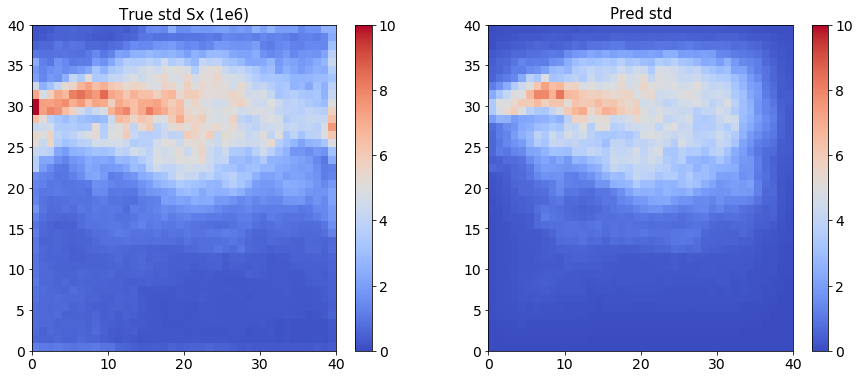

In [28]:
plt.figure(figsize=(15,6))
plt.subplot(121)
c=plt.pcolor(sxt_std*1e6,cmap='coolwarm',vmin=0, vmax=10)#,vmin=-4, vmax=5
cb=plt.colorbar(c)
plt.title('True std Sx (1e6)',fontsize=15)
plt.subplot(122)
c=plt.pcolor(sp_std*1e6,cmap='coolwarm',vmin=0, vmax=10)
#c=plt.pcolor(xt,yt,sp_std*1e6,cmap='coolwarm')#,vmin=-4, vmax=5
cb=plt.colorbar(c)
plt.title('Pred std',fontsize=15)

In [146]:
sxt.shape

(200, 40, 40)

In [29]:
ncf=np.zeros((sxt.shape[1],sxt.shape[2]))
for ni in range(sxt.shape[1]):
    for nj in range(sxt.shape[2]):
        ncf[ni,nj]= np.corrcoef(sxt[:,ni,nj],sp[:,ni,nj])[1,0]   

In [30]:
ncf.max()

0.9403216233115236

In [31]:
ncf[23:38,2:-2].mean()

0.7465891938880956

In [32]:
ncf.mean()

0.5280785883499902

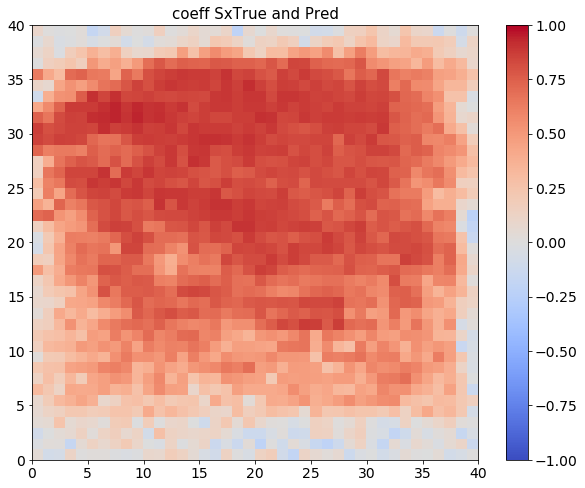

In [33]:
plt.figure(figsize=(10,8))
plt.pcolor(ncf,vmin=-1,vmax=1,cmap='coolwarm')
plt.colorbar()
plt.title('coeff SxTrue and Pred',fontsize=15)
plt.rc('xtick',labelsize=14)

In [34]:
from sklearn import linear_model
xx=plo.flatten()
yy=plm.flatten()

reg1 = linear_model.LinearRegression()
aa1=xx.reshape(-1,1)
bb1=yy.reshape(-1,1)
reg1.fit(aa1,bb1)
d_pred = reg1.predict(aa1)
print(reg1.coef_,reg1.intercept_ )

[[0.80942483]] [-1.68738053e-08]


In [35]:
reg1.score(aa1,bb1)

0.7548134701160855

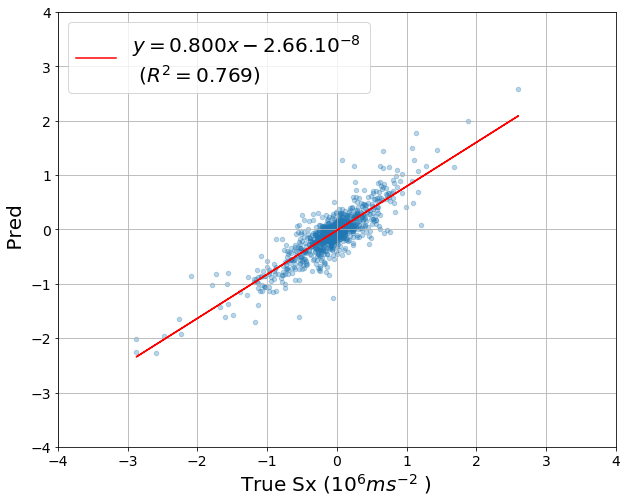

In [36]:
plt.figure(figsize=(10,8))
#for nx in range(xx.shape[0]):
plt.scatter(xx*1e6,yy*1e6,s=20,alpha=0.3)
    #plt.plot(xx[:,nx]*1e6,pr1[:,nx]*1e6,'r',label='-0.06')
plt.ylabel(' Pred',fontsize=20)
plt.xlabel('True Sx ($10^6 ms^{-2}$ ) ',fontsize=20)
plt.grid()
#xl=np.arange(-3,3)
#plt.plot(xl,xl,'g-')
plt.plot(aa1*1e6,d_pred*1e6,color='r',label='$ y = 0.800 x -2.66.10^{-8} $ \n $ (R^2= 0.769)$ ')
plt.legend(fontsize=20)

plt.xlim(-4,4)
plt.ylim(-4,4)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

plt.show()

In [70]:
d_pred = reg1.predict(aa1)

In [74]:
print(reg1.coef_,reg1.intercept_ )

[[0.7056808]] [-6.71473888e-08]


In [64]:
from sklearn.metrics import r2_score,mean_squared_error
r2_score(aa1, bb1)  

0.6035464017792607

In [65]:
mean_squared_error(aa1, bb1)

1.8787196607727484e-13

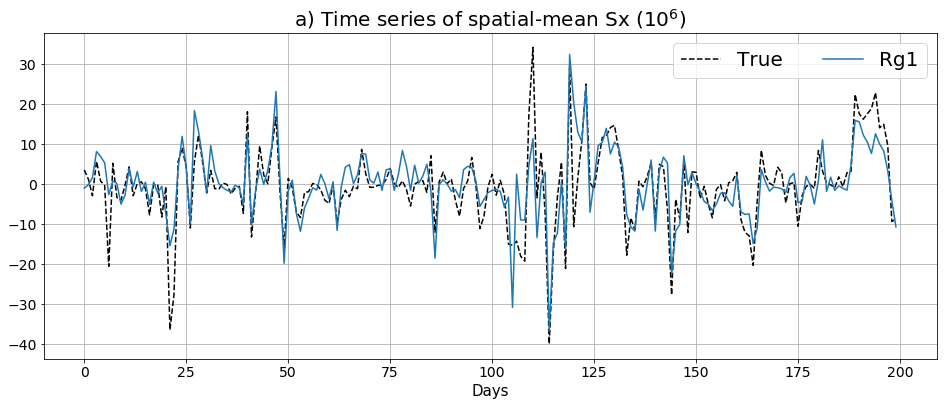

In [40]:
plt.figure(figsize=(16,6))
#plt.plot(e1,'r',label='Test') 
nx1=25
ny1=35
plt.plot(Sx[nti:,ny1,nx1]*1e6,'k--',label='True') 
plt.plot((Spr[:,ny1,nx1]-Spr[:,ny1,nx1].mean())*1e6,label='Rg1') 
#plt.plot((Spr_eb[:,ny1,nx1]-Spr_eb[:,ny1,nx1].mean())*1e6,label='Rg2') 

plt.xlabel('Days',fontsize=15)
#plt.ylabel(' Sx',fontsize=15)
plt.title('a) Time series of spatial-mean Sx ($10^6$)',fontsize=20)
plt.legend(fontsize=20,ncol=4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
#plt.savefig('modloss1.png',dpi=150)
#files.download("modloss1.png") 

In [24]:
npzfile = np.load('/home/datawork-lops-osi/feyan/data_na/comp_NA/SxTrue_NA_720.npz')
SxTrue=npzfile['SxTrue'][-60:]#[:,10:-10,10:-10]
npzfile = np.load('/home/datawork-lops-osi/feyan/data_na/comp_NA/Spr_7202_NA_a.npz')
Sx_wa=npzfile['Spr']#[1:]#[:,10:-10,10:-10]

In [ ]:
from sklearn.metrics import mean_squared_error
def get_rmse(sx1,sT1):
    sp=sx1
    sxt=sT1[-200:]

    rmse=np.zeros((sxt.shape[1],sxt.shape[2]))
    for xi in range (sxt.shape[2]):
        for yi in range (sxt.shape[1]):
            rmse[yi,xi] = np.sqrt(mean_squared_error(sxt[:,yi,xi], sp[:,yi,xi]))
    return rmse

In [171]:
#rms2_wa=get_rmse(Sx_wa,SxTrue)
rms2_lr=get_rmse(Spr,Sx)

In [172]:
rms2_lr.mean()

1.3478323433547913e-06

In [37]:
print(rms2_wa.mean()*1e6,rms2_lr.mean()*1e6)

NameError: name 'rms2_wa' is not defined

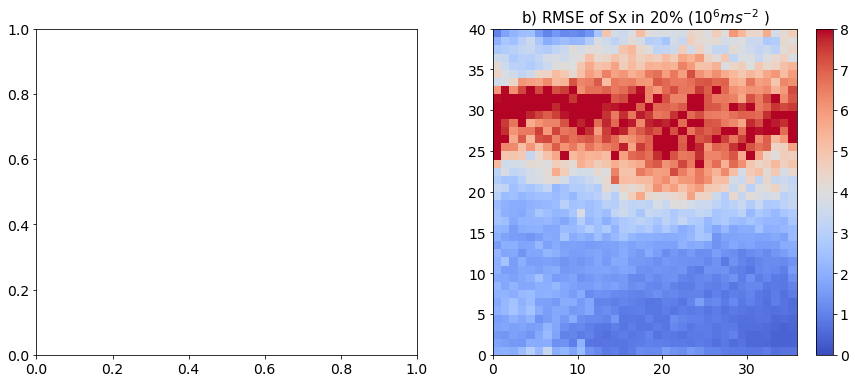

In [38]:
plt.figure(figsize=(15,6))
plt.subplot(121)

plt.subplot(122)
c=plt.pcolor(rms2_lr[:,2:-2]*1e6,vmax=8,vmin=0,cmap='coolwarm')
cb=plt.colorbar(c)
plt.title('b) RMSE of Sx in 20% ($10^6 ms^{-2}$ )',fontsize=15)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
#plt.savefig('rmse1.png', dpi=140)

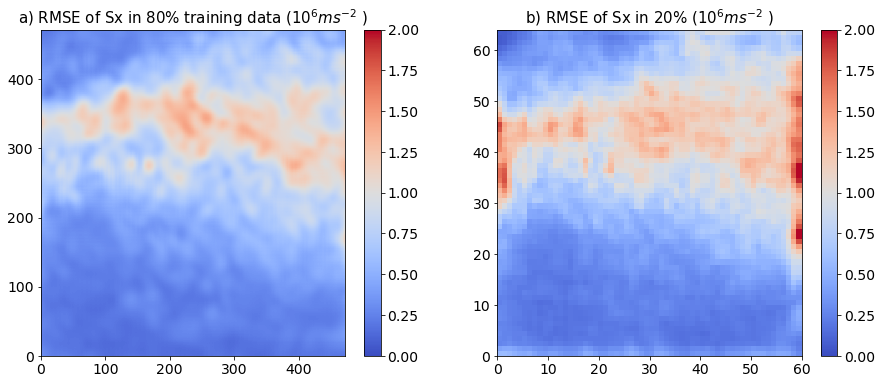

In [30]:
plt.figure(figsize=(15,6))
plt.subplot(121)
c=plt.pcolor(rms2_wa[20:-20,20:-20]*1e6,vmax=2,vmin=0,cmap='coolwarm')
cb=plt.colorbar(c)
plt.title('a) RMSE of Sx in 80% training data ($10^6 ms^{-2}$ )',fontsize=15)
plt.subplot(122)
c=plt.pcolor(rms2_lr[:,2:-2]*1e6,vmax=2,vmin=0,cmap='coolwarm')
cb=plt.colorbar(c)
plt.title('b) RMSE of Sx in 20% ($10^6 ms^{-2}$ )',fontsize=15)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
#plt.savefig('rmse1.png', dpi=140)

In [25]:
Sx_wb=Spr[-60:]
sxt_std=np.std(SxTrue,axis=0)
std_wa=np.std(Sx_wa,axis=0)
std_wb=np.std(Sx_wb,axis=0)

In [26]:
def get_corr(sx1, ST1):
    sp=sx1
    sxt=ST1[-200:]
    
    ncl=np.zeros((sxt.shape[1],sxt.shape[2]))
    for ni in range(sxt.shape[1]):
        for nj in range(sxt.shape[2]):
            ncl[ni,nj]= np.corrcoef(sxt[:,ni,nj],sp[:,ni,nj])[1,0]   
    return ncl

In [27]:
ncl_wa= get_corr(Sx_wa,SxTrue)
ncl_wb= get_corr(Sx_wb,Sx[-60:])
print(ncl_wa.mean(),ncl_wb.mean())

0.5700197489822036 0.49987344034850095


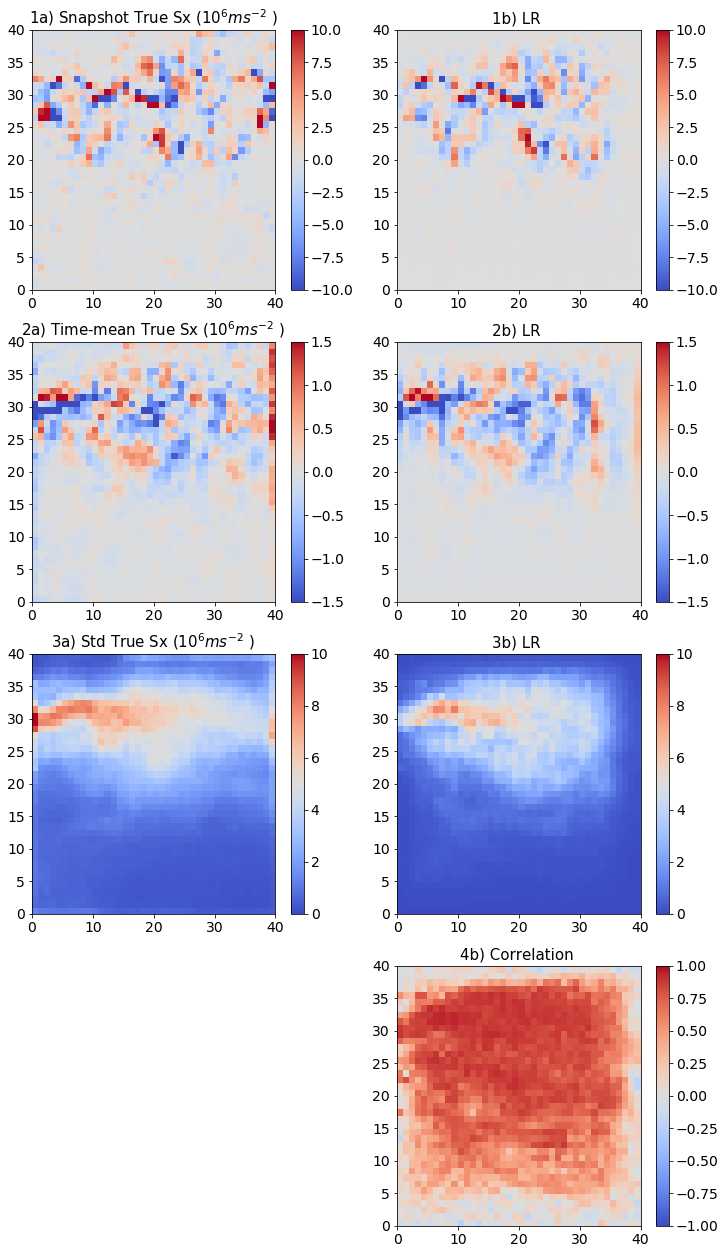

In [161]:
sxt_std=np.std(Sx,axis=0)
sp_std=np.std(Spr,axis=0)
ncf= get_corr(Spr,Sx)


nti=int(um.shape[0]*.8)
plt.figure(figsize=(12,22))
ni=5
plt.subplot(421)
plt.pcolor(Sx[nti+ni]*1e6,cmap='coolwarm',vmax=10,vmin=-10)#,,
cb=plt.colorbar()
plt.title('1a) Snapshot True Sx ($10^6 ms^{-2}$ ) ',fontsize=15)

plt.subplot(422)
plt.pcolor((Spr[ni])*1e6,cmap='coolwarm',vmax=10,vmin=-10)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('1b) LR ',fontsize=15)


plt.subplot(423)
plt.pcolor(Sx[-200:].mean(axis=0)*1e6,cmap='coolwarm',vmax=1.5,vmin=-1.5)#,,
cb=plt.colorbar()
plt.title('2a) Time-mean True Sx ($10^6 ms^{-2}$ ) ',fontsize=15)


plt.subplot(424)
plt.pcolor((Spr.mean(axis=0))*1e6,cmap='coolwarm',vmax=1.5,vmin=-1.5)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('2b) LR ',fontsize=15)



plt.subplot(425)
plt.pcolor(sxt_std*1e6,cmap='coolwarm',vmax=10,vmin=0)#,,
cb=plt.colorbar()
plt.title('3a) Std True Sx ($10^6 ms^{-2}$ ) ',fontsize=15)

plt.subplot(426)
plt.pcolor(sp_std*1e6,cmap='coolwarm',vmax=10,vmin=0)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('3b) LR ',fontsize=15)



plt.subplot(4,2,8)
plt.pcolor(ncf,cmap='coolwarm',vmax=1,vmin=-1)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('4b) Correlation ',fontsize=15)


plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

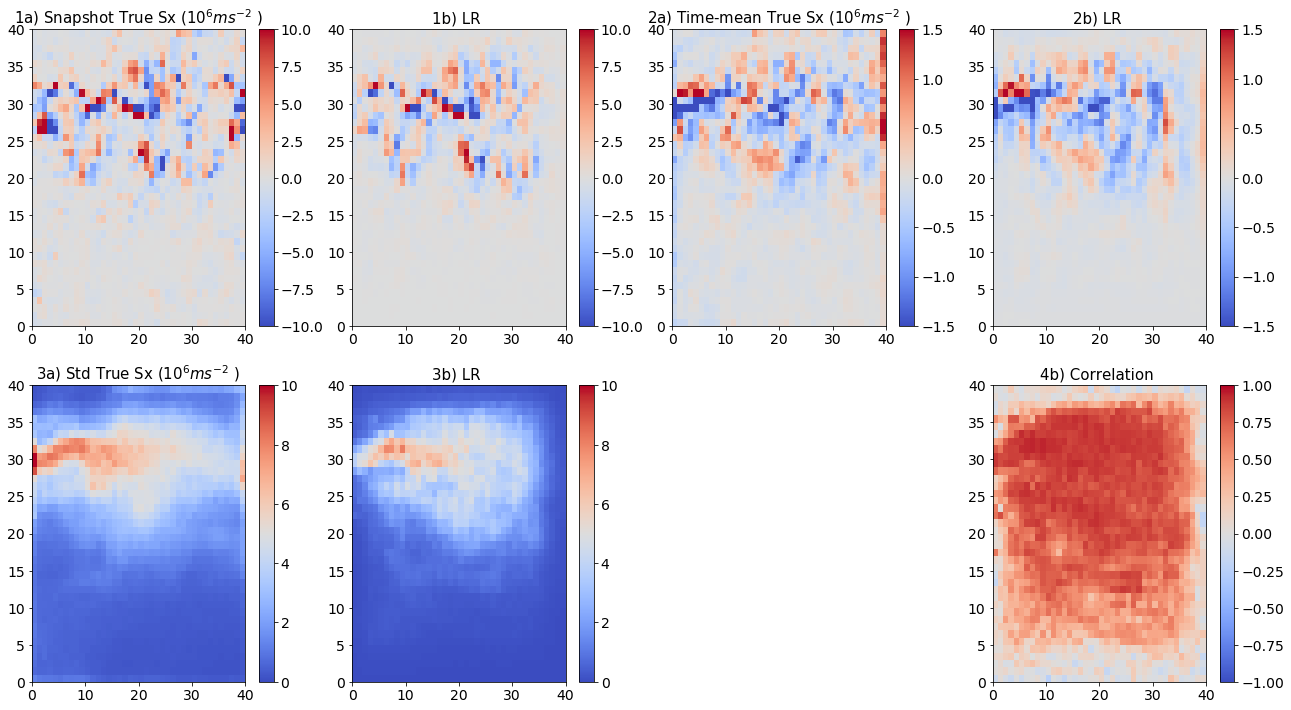

In [162]:
nti=int(um.shape[0]*.8)
plt.figure(figsize=(22,12))
ni=5
plt.subplot(241)
plt.pcolor(Sx[nti+ni]*1e6,cmap='coolwarm',vmax=10,vmin=-10)#,,
cb=plt.colorbar()
plt.title('1a) Snapshot True Sx ($10^6 ms^{-2}$ ) ',fontsize=15)

plt.subplot(242)
plt.pcolor((Spr[ni])*1e6,cmap='coolwarm',vmax=10,vmin=-10)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('1b) LR ',fontsize=15)


plt.subplot(243)
plt.pcolor(Sx[-200:].mean(axis=0)*1e6,cmap='coolwarm',vmax=1.5,vmin=-1.5)#,,
cb=plt.colorbar()
plt.title('2a) Time-mean True Sx ($10^6 ms^{-2}$ ) ',fontsize=15)


plt.subplot(244)
plt.pcolor((Spr.mean(axis=0))*1e6,cmap='coolwarm',vmax=1.5,vmin=-1.5)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('2b) LR ',fontsize=15)



plt.subplot(245)
plt.pcolor(sxt_std*1e6,cmap='coolwarm',vmax=10,vmin=0)#,,
cb=plt.colorbar()
plt.title('3a) Std True Sx ($10^6 ms^{-2}$ ) ',fontsize=15)

plt.subplot(246)
plt.pcolor(sp_std*1e6,cmap='coolwarm',vmax=10,vmin=0)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('3b) LR ',fontsize=15)



plt.subplot(248)
plt.pcolor(ncf,cmap='coolwarm',vmax=1,vmin=-1)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('4b) Correlation ',fontsize=15)


plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

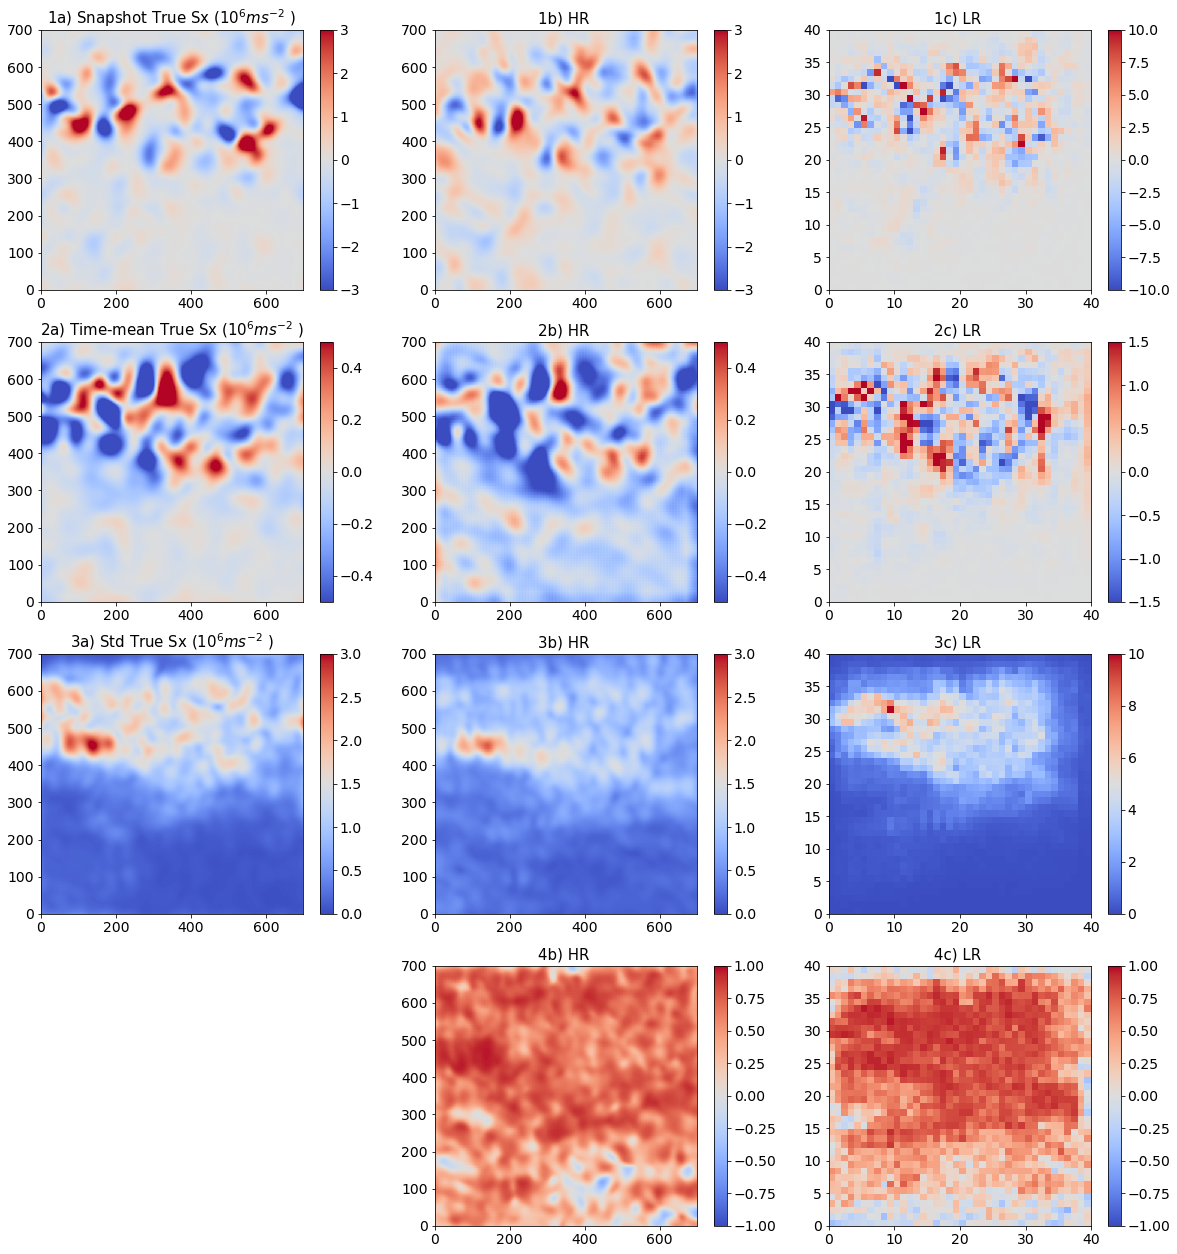

In [29]:
plt.figure(figsize=(20,22))
ni=15
plt.subplot(431)
plt.pcolor(SxTrue[ni,10:-10,10:-10]*1e6,cmap='coolwarm',vmax=3,vmin=-3)#,,
cb=plt.colorbar()
plt.title('1a) Snapshot True Sx ($10^6 ms^{-2}$ ) ',fontsize=15)

plt.subplot(432)
plt.pcolor((Sx_wa[ni,10:-10,10:-10]-Sx_wa[:,10:-10,10:-10].mean(axis=0))*1e6,cmap='coolwarm',vmax=3,vmin=-3)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('1b) HR ',fontsize=15)

plt.subplot(433)
plt.pcolor((Sx_wb[ni]-Sx_wb[:].mean(axis=0))*1e6,cmap='coolwarm',vmax=10,vmin=-10)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('1c) LR ',fontsize=15)


plt.subplot(434)
plt.pcolor(SxTrue[:,10:-10,10:-10].mean(axis=0)*1e6,cmap='coolwarm',vmax=.5,vmin=-.5)#,,
cb=plt.colorbar()
plt.title('2a) Time-mean True Sx ($10^6 ms^{-2}$ ) ',fontsize=15)

plt.subplot(435)
plt.pcolor((Sx_wa[:,10:-10,10:-10].mean(axis=0))*1e6,cmap='coolwarm',vmax=.5,vmin=-.5)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('2b) HR ',fontsize=15)

plt.subplot(436)
plt.pcolor((Sx_wb.mean(axis=0))*1e6,cmap='coolwarm',vmax=1.5,vmin=-1.5)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('2c) LR ',fontsize=15)



plt.subplot(437)
plt.pcolor(sxt_std[10:-10,10:-10]*1e6,cmap='coolwarm',vmax=3,vmin=0)#,,
cb=plt.colorbar()
plt.title('3a) Std True Sx ($10^6 ms^{-2}$ ) ',fontsize=15)

plt.subplot(438)
plt.pcolor(std_wa[10:-10,10:-10]*1e6,cmap='coolwarm',vmax=3,vmin=0)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('3b) HR ',fontsize=15)

plt.subplot(439)
plt.pcolor(std_wb*1e6,cmap='coolwarm',vmax=10,vmin=0)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('3c) LR ',fontsize=15)


plt.subplot(4,3,11)
plt.pcolor(ncl_wa[10:-10,10:-10],cmap='coolwarm',vmax=1,vmin=-1)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('4b) HR ',fontsize=15)

plt.subplot(4,3,12)
plt.pcolor(ncl_wb,cmap='coolwarm',vmax=1,vmin=-1)#,,,vmax=0.024,vmin=-0.04
cb=plt.colorbar()
plt.title('4c) LR ',fontsize=15)



plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)